In [1]:
# Import all needed libraries for our project
import os
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.src.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.src.models import Sequential

### Prepare data

In [2]:
# Emotion label mapping (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
label_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}
reverse_label_map = {v: k for k, v in label_map.items()}

# Load the images and labels from the dataset folder
def load_data(data_folder):
    emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    images = []
    labels = []
    for emotion in emotions:
        emotion_dir = os.path.join(data_folder, emotion)
        for img_dir in os.listdir(emotion_dir):
            img = cv2.imread(os.path.join(emotion_dir, img_dir), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(emotion)
    return images, labels

def preprocess_data(image):
    # Normalize the image (scale the pixel values to [0, 1])
    image = image / 255.0
    # if len(image.shape) == 2:
    #     image = np.stack([image] * 3, axis=-1)
    return image


def save_preprocessed_data(data, labels, data_file, label_file):
    np.save(data_file, data)
    np.save(label_file, labels)

def load_preprocessed_data(data_file, label_file):
    data = np.load(data_file)
    labels = np.load(label_file)
    return data, labels

def prepare_data(train_folder, test_folder):
    # Load and preprocess training data
    if not os.path.exists('preprocessed_train_imgs.npy') or not os.path.exists('train_labels.npy'):
        print("Loading and preprocessing train data...")
        train_imgs, train_labels = load_data(train_folder)
        preprocess_train_imgs = [preprocess_data(img) for img in train_imgs]
        preprocess_train_imgs = np.array(preprocess_train_imgs, dtype=np.float32)
        train_labels = np.array([label_map[label] for label in train_labels], dtype=np.int32)
        save_preprocessed_data(preprocess_train_imgs, train_labels, 'preprocessed_train_imgs.npy', 'train_labels.npy')
    else:
        print("Loading preprocessed train data from disk...")
        preprocess_train_imgs, train_labels = load_preprocessed_data('preprocessed_train_imgs.npy', 'train_labels.npy')

    # Load and preprocess testing data
    if not os.path.exists('preprocessed_test_imgs.npy') or not os.path.exists('test_labels.npy'):
        print("Loading and preprocessing test data...")
        test_imgs, test_labels = load_data(test_folder)
        preprocess_test_imgs = [preprocess_data(img) for img in test_imgs]
        preprocess_test_imgs = np.array(preprocess_test_imgs, dtype=np.float32)
        test_labels = np.array([label_map[label] for label in test_labels], dtype=np.int32)
        save_preprocessed_data(preprocess_test_imgs, test_labels, 'preprocessed_test_imgs.npy', 'test_labels.npy')
    else:
        print("Loading preprocessed test data from disk...")
        preprocess_test_imgs, test_labels = load_preprocessed_data('preprocessed_test_imgs.npy', 'test_labels.npy')

    return preprocess_train_imgs, train_labels, preprocess_test_imgs, test_labels

### Train model

In [3]:
# Build the CNN model
def create_cnn_model():
    model = tf.keras.Sequential([
        # 1st convolution layer with 32 filters (uses ReLU activation function)
        Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        # 1st max pooling layer (2 x 2 pool size)
        # reduces spatial dimensions (height & width) to decrease computational load & help with overfitting
        MaxPooling2D((2, 2)),
        # 2nd convolution layer with 64 filters
        Conv2D(64, (3, 3), activation='relu'),
        # 2nd max pooling layer
        MaxPooling2D((2, 2)),
        # 3rd conv layer with 128 filters
        Conv2D(128, (3, 3), activation='relu'),
        # 3rd max pooling
        MaxPooling2D((2, 2)),
        # flatten 3D output from previous layer to 1D (needed for fully connected layers)
        Flatten(),
        # fully connected layer with 128 units
        # this final dense layer uses the learned features to output probs for each of the 7 emotions
        # and the one with the highest probs is the predicted one
        Dense(128, activation='relu'),
        # 7 classes for emotions (output layer)
        Dense(7, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def augment_data(train_imgs, train_labels):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    augmented_data = data_gen.flow(train_imgs, train_labels, batch_size=128)
    return augmented_data

# Train the model
def train_model(model, train_imgs, train_labels, val_imgs, val_labels):
    augmented_data = augment_data(train_imgs, train_labels)
    train_logs = model.fit(augmented_data, epochs=15, validation_data=(val_imgs, val_labels))
    model.save('emotion_cnn_model.keras')
    return train_logs

# Evaluate the model on test data
def evaluate_model(model, test_imgs, test_labels):
    test_loss, test_accuracy = model.evaluate(test_imgs, test_labels)
    print(f'Test accuracy: {test_accuracy:.2f}')

# Display images with true and predicted labels
def plot_images(images, labels, predicted_labels=None):
    rand_indices = np.random.choice(len(images), 20, replace=False)
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(rand_indices):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[idx].reshape(48, 48), cmap='gray')
        true_label = reverse_label_map[labels[rand_indices[i]]]
        title = f'True: {true_label}'
        if predicted_labels is not None:
            predicted_label = reverse_label_map[predicted_labels[rand_indices[i]]]
            title += f'\nPred: {predicted_label}'
        plt.title(title)
        plt.axis('off')
    plt.show()


Loading and preprocessing train data...
Loading and preprocessing test data...


C:\Users\phear\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\phear\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.2453 - loss: 1.8168 - val_accuracy: 0.3211 - val_loss: 1.6854
Epoch 2/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.3260 - loss: 1.6902 - val_accuracy: 0.4134 - val_loss: 1.5147
Epoch 3/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.3957 - loss: 1.5614 - val_accuracy: 0.4056 - val_loss: 1.5325
Epoch 4/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.4416 - loss: 1.4692 - val_accuracy: 0.4547 - val_loss: 1.3944
Epoch 5/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4528 - loss: 1.4152 - val_accuracy: 0.5096 - val_loss: 1.2989
Epoch 6/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4824 - loss: 1.3540 - val_accuracy: 0.4993 - val_loss: 1.3099
Epoch 7/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5039 - loss: 1.3106 - val_accuracy: 0.5216 - val_loss: 1.2523
Epoch 8/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5117 - loss: 1.2854 - val_accu

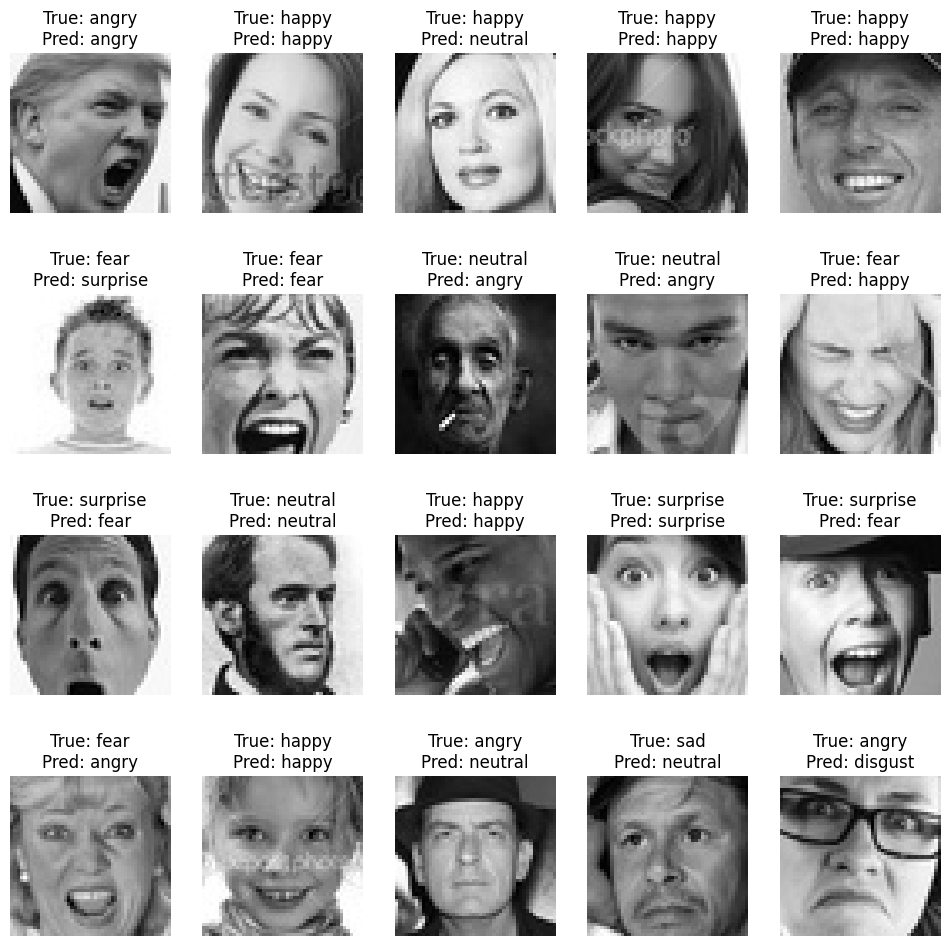

In [4]:
def main():
    # Paths to the train and test folders
    train_folder = './data/train'
    test_folder = './data/test'
    
    # Prepare data
    preprocess_train_imgs, train_labels, preprocess_test_imgs, test_labels = prepare_data(train_folder, test_folder)
    
    # Split training data into train and validation sets
    train_imgs, val_imgs, train_labels, val_labels = train_test_split(
        preprocess_train_imgs, train_labels, test_size=0.2, random_state=42)
    
    # Add the channel axis (grayscale images have one channel)
    train_imgs = np.expand_dims(train_imgs, axis=-1)
    val_imgs = np.expand_dims(val_imgs, axis=-1)
    test_imgs = np.expand_dims(preprocess_test_imgs, axis=-1)

    # Build and train the CNN model
    model = create_cnn_model()
    training_log = train_model(model, train_imgs, train_labels, val_imgs, val_labels)
    
    # Evaluate the model on test data
    evaluate_model(model, test_imgs, test_labels)
    
    # Make predictions on the test set
    predictions = model.predict(test_imgs)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Visualize predictions on the test set
    plot_images(test_imgs, test_labels, predicted_classes)
    
if __name__ == "__main__":
    main()

In [5]:
# Load the trained emotion recognition model
model = tf.keras.models.load_model('emotion_cnn_model.keras')

# Emotion label mapping
label_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}
reverse_label_map = {v: k for k, v in label_map.items()}

# Initialize the webcam (0 is the default webcam)
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not access the webcam.")
    exit()

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    # Capture a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to grab frame.")
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the region of interest
        roi_gray = gray[y:y+h, x:x+w]

        # Resize and normalize the image
        resized_face = cv2.resize(roi_gray, (48, 48))
        normalized_face = resized_face / 255.0

        # Prepare the image for the model
        # Shape: (48, 48, 1)
        input_face = np.expand_dims(normalized_face, axis=-1)
        # Shape: (1, 48, 48, 1)
        input_face = np.expand_dims(input_face, axis=0)

        # Make a prediction
        prediction = model.predict(input_face)
        predicted_class = np.argmax(prediction, axis=1)[0]
        predicted_emotion = reverse_label_map[predicted_class]

        # Draw rectangle and label
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Emotion Recognition', frame)

    # Exit the program when q is pressed or when user clicked on X icon (top-right of program)
    if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty('Emotion Recognition', cv2.WND_PROP_VISIBLE) < 1:
        break

# Release webcam and close windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━